# Learning forcing terms for SPDE
Wave SPDE from "Numerical solution of the (stochastic) wave equation"
from JOHN B. WALSH, see: https://www.math.ubc.ca/~walsh/waveq.pdf

### Define stochastic wave equation:

$$
\frac{\partial^2 u}{\partial t^2}=\frac{\partial^2 u}{\partial x^2}+f(x,t,u)+g(x,t,u)\dot{W},\ x\in\mathbb{R}, t\in\mathbb{R}^+,
$$

$$
u(x,0)=u_0(x),\ \frac{\partial u}{\partial t}(x,0)=v_0(x),\ x\in\mathbb{R}.
$$

Here, $f$ is the deterministic and $g$ the stochastic forcing term. We show how to learn these from SPDE data.

In [109]:
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.spde_utils import SPDEUtils

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    mean_min_loss,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
# notebook parameters
n_dimensions = 1
step_size = 1e-3
space_size = 1
time_size = 2
space = np.arange(int(space_size/step_size))*step_size
time = np.arange(int(time_size/step_size))*step_size

random_seed = 1


In [111]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**8, 
                                M_min=50,
                                M_max=100,
                                gamma=1,
                                delta=0.2,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               gamma=drift_param.gamma,
                               delta=0.4,
                               name='diff')


In [113]:
# true functions parameters

# these are the forcing terms we want to learn
f = lambda x, t, u: np.sin(4*np.pi*x) * 5
g = lambda x, t, u: 0.05 * (1 + np.exp(-(x-space_size/2)**2 * 150))

# inital conditions
u0 = np.zeros((len(space),)) + np.sin(2*np.pi*space) * 0 + np.exp(-(space-space_size/2)**2 * 150)/20
v0 = np.zeros((len(space),))
v0 = -np.gradient(u0, step_size)*2  # define initial velocity such that the wave moves to the right

step_size_network = 0.5 * step_size ** 2


In [136]:
def true_drift(x):
    x = np.atleast_2d(x)
    x = x[:,1]
    return (np.sin(4*np.pi*x) * 5).reshape(-1, 1)


def true_diffusion(x):
    x = np.atleast_2d(x)
    x = x[:,1]
    return 0.05 * (1 + np.exp(-(x-space_size/2)**2 * 150)).reshape(-1, 1, 1)


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)
    

# the diffusion we intend to learn in the training process - that appears in the EM integration of the SPDE
def target_diffusion(x):
    return 0.5 * true_diffusion(x)
    

ulim = np.array([[0, 1]])
plim = np.array([[0, time_size], [0, space_size]])

step_size_new = 0.5 * step_size ** 2

In [134]:
# calculate theoretical mean min loss (integral over loss function across input domain)
mean_min_loss(target_diffusion, u_n.shape[0], validation_split, step_size_new, ulim, xlim=plim, YinX=False, save=True)


Theoretical mean min loss: -9.41353752078328
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


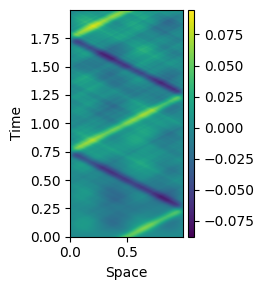

drift epoch: 50


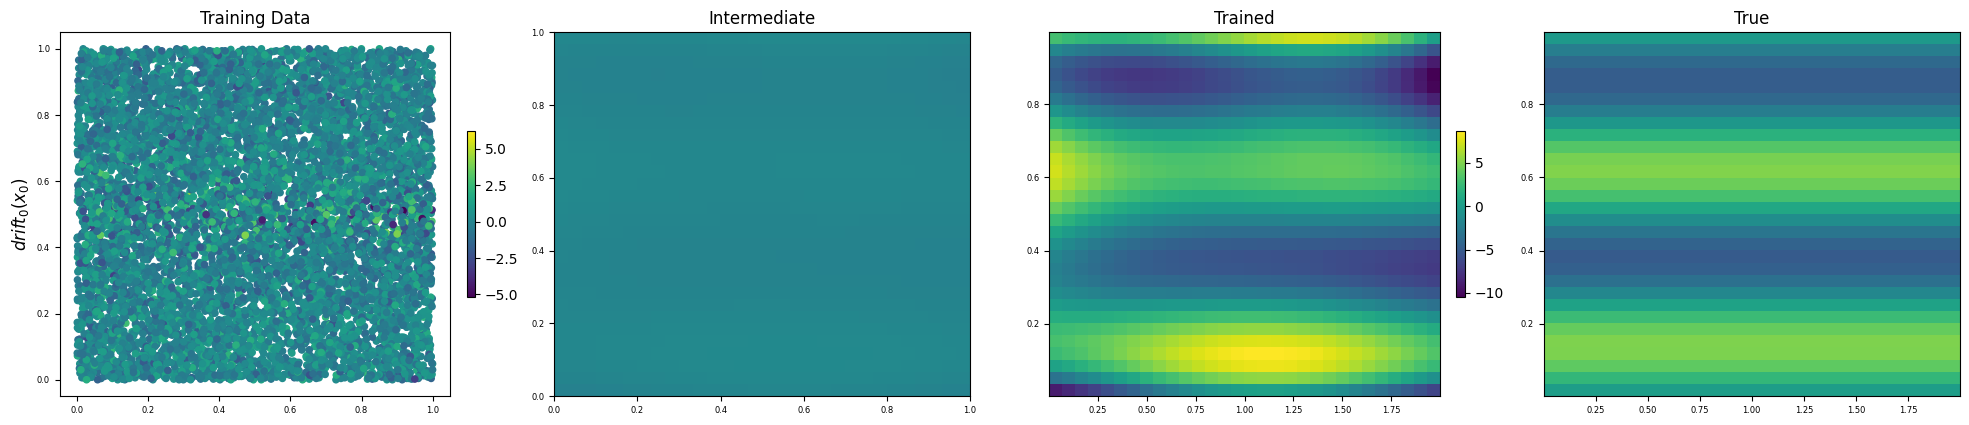

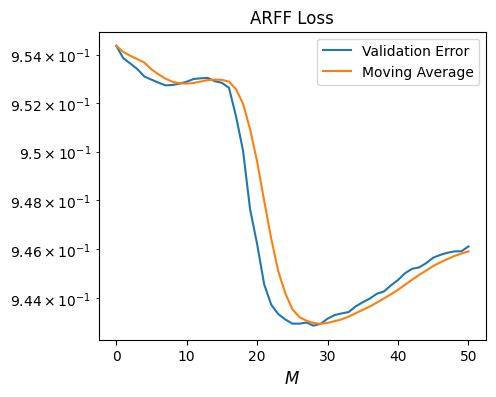

diff epoch: 59


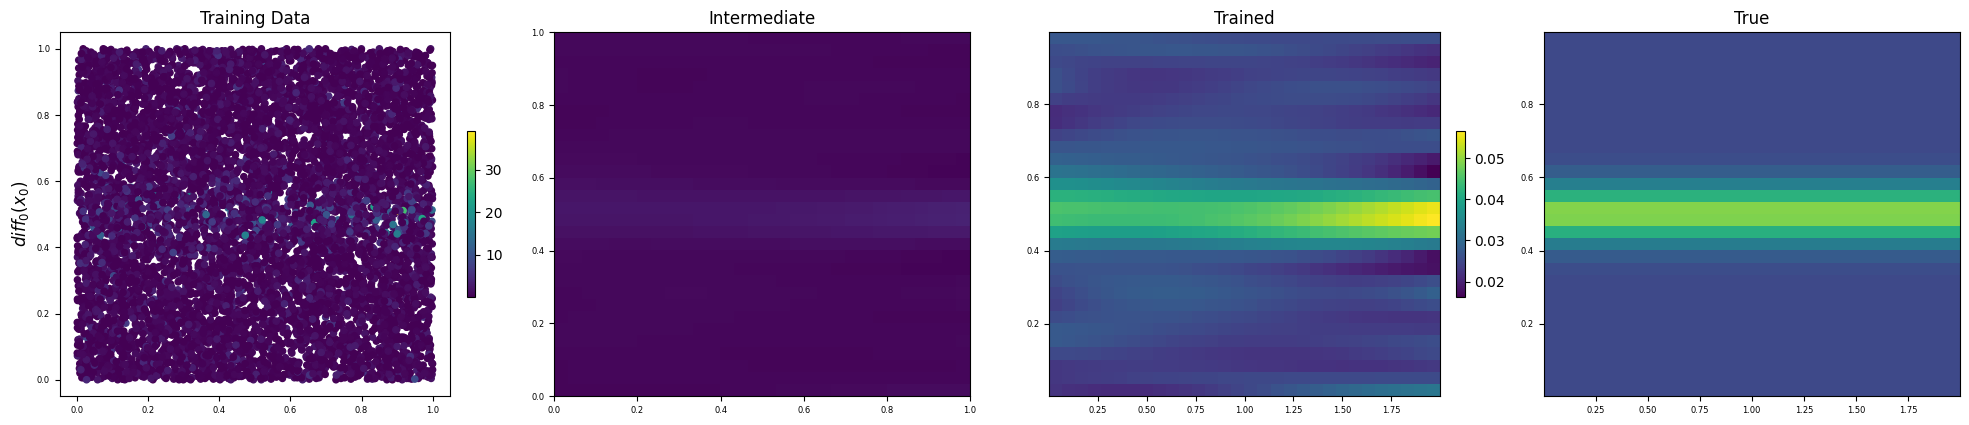

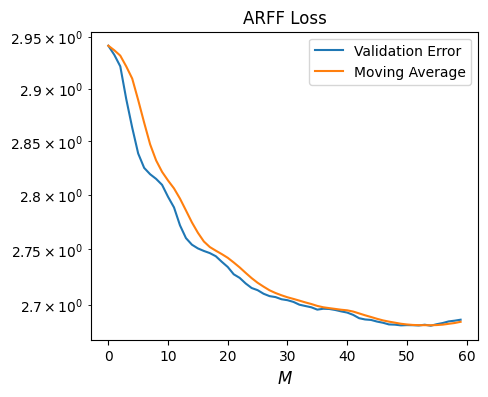

Observed loss: -9.422459738516004
Observed validation loss: -9.408354670118843
Training time: 32.90838646888733


In [156]:
# train networks
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed + i)
    tf.random.set_seed(random_seed)

    # generate data
    ut = SPDEUtils.integrate_stochastic_wave(u0, v0, f, g, time, space, random_seed=random_seed, periodic_boundary=False)
    u_n, p_n, u_np1 = SPDEUtils.split_forced_wave_spde_data(ut, space[::2], time)
    if i == 0:
        SPDEUtils.plot_data(ut, space, time)

    random_indices = np.random.choice(u_n.shape[0], 10000, replace=False)
    u_n = u_n[random_indices, :]
    u_np1 = u_np1[random_indices, :]
    p_n = p_n[random_indices, :]
    step_sizes_network = np.zeros((u_n.shape[0], 1)) + step_size_network

    # build network
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, rng=rng, resampling=True)

    # train network
    hist = SAT.train_model(drift_param, diff_param, true_drift, target_diffusion, u_n, u_np1, p_n, step_sizes=step_sizes_network, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, YinX=False, plot=True)
    
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]
        
        

In [141]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=False)

def trained_drift_diffusion(x):
    return SAT.drift(x), 2 * SAT.diff(x)

PR.plot_parameter_functions(trained_drift_diffusion, true_drift_diffusion, p_n, save=False)

# time = 100*step_size
# PR.plot_histogram(true_drift_diffusion, step_size/n_subsample, time, rng, xlim, name='True', save=False)
# PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, xlim, name='Adam', save=False)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

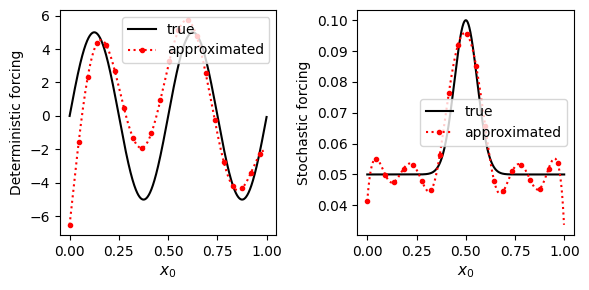

In [142]:
def plot_forcings_space(ut):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    f_true = f(space, time[0], ut[0, :])
    g_true = g(space, time[0], ut[0, :])
    state_k = np.array([ut[0, :]]).reshape(-1, 1)*1
    param_k = np.zeros((ut.shape[1], 2))
    param_k[:, 0] = time[0]
    param_k[:, 1] = space[::2]
    f_approx = SAT.drift(space[::2].reshape(-1,1))
    g_approx = 2 * SAT.diff(space[::2].reshape(-1,1))
    
    ax[0].plot(space, f_true, "-", color="black", label="true")
    ax[0].plot(space[::2], f_approx, ".:", markevery=len(space)//42, color="red", label="approximated")
    ax[0].set_xlabel(r'$x_0$', fontsize=11)
    ax[0].set_ylabel('Deterministic forcing')
    ax[0].legend(loc='upper right')

    ax[1].plot(space, g_true, "-", color="black", label="true")
    ax[1].plot(space[::2], g_approx.reshape(param_k.shape[0], 1), ".:", markevery=len(space)//42, color="red", label="approximated")
    ax[1].set_xlabel(r'$x_0$', fontsize=11)
    ax[1].set_ylabel('Stochastic forcing')
    ax[1].legend(loc='right')

    fig.tight_layout()

plot_forcings_space(ut)



In [ ]:
def get_loss2(y_n, y_np1, x, step_sizes, diff_type="diagonal"):

    #drift_ = SAT.drift(x)
    #diffusivity_ = np.sqrt(step_size ** 2 / step_size * 2) * SAT.diff(x)
    drift_ = true_drift(x)
    diffusivity_ = true_diffusivity(x)

    loc = y_n + step_sizes * drift_
    scale = np.sqrt(0.5) * diffusivity_
    if diff_type == "spd":
        scale = tf.linalg.matmul(scale, tf.linalg.matrix_transpose(scale))
        scale = tf.linalg.cholesky(scale)
    
    loc = tf.convert_to_tensor(loc, dtype=tf.float64)
    scale = tf.convert_to_tensor(scale, dtype=tf.float64)
    
    if diff_type == "diagonal":
        approx_normal = tfd.MultivariateNormalDiag(
            loc=loc,
            scale_diag=np.diagonal(scale, axis1=1, axis2=2),
            name="approx_normal"
        )
    else:
        approx_normal = tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale,
            name="approx_normal"
        )

    log_prob = approx_normal.log_prob(y_np1)
    sample_distortion = -tf.reduce_mean(log_prob, axis=-1)
    distortion = tf.reduce_mean(sample_distortion)

    additive_constant = 0
    loss = distortion + additive_constant
    return loss

random_indices = np.random.choice(u_n.shape[0], 10000, replace=False)
u_n_loss2 = u_n[random_indices, :]
u_np1_loss2 = u_np1[random_indices, :]
p_n_loss2 = p_n[random_indices, :]
step_sizes_loss2 = step_sizes[random_indices].reshape(-1, 1)

print(get_loss(u_n_loss2, u_np1_loss2, p_n_loss2, step_sizes_loss2))

In [93]:
def get_loss(y_n, y_np1, x, step_sizes, diff_type="diagonal"):

    drift_ = SAT.drift(x)
    diffusivity_ = np.sqrt(2) * SAT.diff(x)
    #drift_ = true_drift(x)
    #diffusivity_ = true_diffusivity(x)

    loc = y_n + step_sizes * drift_
    scale = diffusivity_
    if diff_type == "spd":
        scale = tf.linalg.matmul(scale, tf.linalg.matrix_transpose(scale))
        scale = tf.linalg.cholesky(scale)
    
    loc = tf.convert_to_tensor(loc, dtype=tf.float64)
    scale = tf.convert_to_tensor(scale, dtype=tf.float64)
    
    if diff_type == "diagonal":
        approx_normal = tfd.MultivariateNormalDiag(
            loc=loc,
            scale_diag=np.diagonal(scale, axis1=1, axis2=2),
            name="approx_normal"
        )
    else:
        approx_normal = tfd.MultivariateNormalTriL(
            loc=loc,
            scale_tril=scale,
            name="approx_normal"
        )

    log_prob = approx_normal.log_prob(y_np1)
    sample_distortion = -tf.reduce_mean(log_prob, axis=-1)
    distortion = tf.reduce_mean(sample_distortion)

    additive_constant = 0
    loss = distortion + additive_constant
    return loss

In [124]:
val_loss = np.zeros(No_of_tests)

def trained_diffusion(x):
    return SAT.diff(x)
val_loss[i] = SAT.get_loss(u_n, u_np1, p_n, step_sizes_new, drift=SAT.drift, diffusion=trained_diffusion)

def true_diffusion(x):
    return 0.5 * true_diffusivity(x)
true_loss = SAT.get_loss(u_n, u_np1, p_n, step_sizes_new, drift=true_drift, diffusion=true_diffusion)



# val_loss = get_loss(u_n, u_np1, p_n, step_sizes_new)
# true_loss = get_loss2(u_n, u_np1, p_n, step_sizes_new)


print(val_loss, true_loss)

[-9.42387033] tf.Tensor(-9.420071590351522, shape=(), dtype=float64)


In [57]:
# No_of_tests = 1
# training_time = np.zeros(No_of_tests)
# val_loss = np.zeros(No_of_tests)

# for i in range(No_of_tests):
#     SAT = SDEAMTrain(n_dimensions=n_dimensions)
#     hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusivity, u_n, u_np1, p_n, step_sizes=step_sizes, validation_split=validation_split, AM_validation_split=AM_validation_split, XinY=False, plot=True)
#     training_time[i] = hist.history["training_time"]
    
#     random_indices = np.random.choice(u_n.shape[0], 100000, replace=False)
#     u_n_loss = u_n[random_indices, :]
#     u_np1_loss = u_np1[random_indices, :]
#     p_n_loss = p_n[random_indices, :]
#     step_sizes_loss = step_sizes[random_indices].reshape(-1, 1)
#     val_loss[i] = get_loss(u_n_loss, u_np1_loss, p_n_loss, step_sizes_loss)

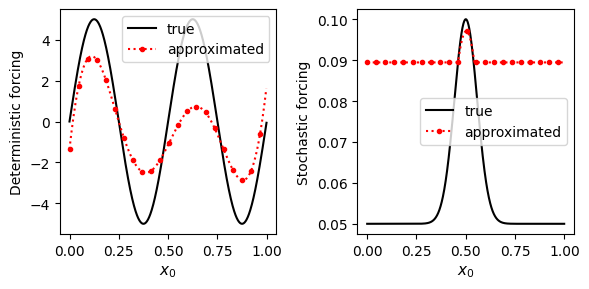

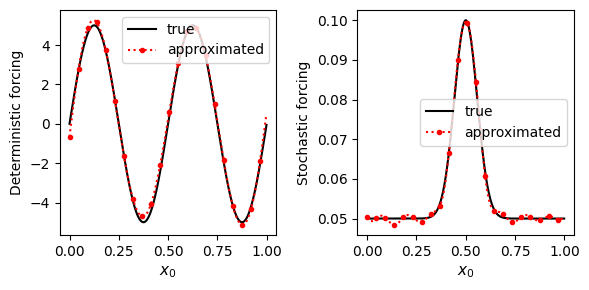

In [26]:
# visualize the results against the true forcing functions

def plot_forcings_space(ut):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))

    f_true = f(space, time[0], ut[0, :])
    g_true = g(space, time[0], ut[0, :])
    state_k = np.array([ut[0, :]]).reshape(-1, 1)*1
    param_k = np.zeros((ut.shape[1], 2))
    param_k[:, 0] = time[0]
    param_k[:, 1] = space[::2]
    f_approx = SAT.drift(space[::2].reshape(-1,1))
    #model_f, model_g = model.call_xn(state_k, param_xn=param_k)
    #f_approx = tf.keras.backend.eval(model_f).ravel()

    # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
    #g_approx = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()
    g_approx = np.sqrt(step_size ** 2 / step_size * 2) *SAT.diff(space[::2].reshape(-1,1))
    
    ax[0].plot(space, f_true, "-", color="black", label="true")
    ax[0].plot(space[::2], f_approx, ".:", markevery=len(space)//42, color="red", label="approximated")
    ax[0].set_xlabel(r'$x_0$', fontsize=11)
    ax[0].set_ylabel('Deterministic forcing')
    ax[0].legend(loc='upper right')

    ax[1].plot(space, g_true, "-", color="black", label="true")
    ax[1].plot(space[::2], g_approx.reshape(param_k.shape[0], 1), ".:", markevery=len(space)//42, color="red", label="approximated")
    ax[1].set_xlabel(r'$x_0$', fontsize=11)
    ax[1].set_ylabel('Stochastic forcing')
    ax[1].legend(loc='right')

    fig.tight_layout()

    # fig.savefig('figures/example7_wave_spde_forcings.pdf')
    # fig.savefig('figures/example7_wave_spde_forcings.png')

    output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
    output_path = os.path.join(output_dir, "ex7 - Wave SPDE")
    fig.savefig(output_path, dpi=300, bbox_inches='tight')


def plot_forcings(ut):
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    divider1 = make_axes_locatable(ax[0])
    divider2 = make_axes_locatable(ax[1])
    divider3 = make_axes_locatable(ax[2])
    divider4 = make_axes_locatable(ax[3])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    cax2 = divider2.append_axes('right', size='5%', pad=0.05)
    cax3 = divider3.append_axes('right', size='5%', pad=0.05)
    cax4 = divider4.append_axes('right', size='5%', pad=0.05)

    f_true = np.zeros((len(time), len(space)))
    g_true = np.zeros((len(time), len(space)))
    f_approx = np.zeros((len(time), len(space)//2))
    g_approx = np.zeros((len(time), len(space)//2))
    for k in range(len(time)):
        f_true[k, :] = f(space, time[k], ut[k, :])
        g_true[k, :] = g(space, time[k], ut[k, :])
        state_k = np.array([ut[k, :]]).reshape(-1, 1)*1
        param_k = np.zeros((ut.shape[1], 2))
        param_k[:, 0] = time[k]
        param_k[:, 1] = space[::2]
        #model_f, model_g = model.call_xn(state_k, param_xn=param_k)
        #f_approx[k, :] = tf.keras.backend.eval(model_f).ravel()
        f_approx = SAT.drift(space[::2].reshape(-1,1))

        # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
        #g_approx[k, :] = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()
        g_approx = 2*SAT.diff(space[::2].reshape(-1,1))

    im1 = ax[0].imshow(f_true, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-20, vmax=20)
    ax[0].set_xlabel('Space')
    ax[0].set_ylabel('Time')
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    im2 = ax[1].imshow(f_approx, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-20, vmax=20)
    ax[1].set_xlabel('Space')
    ax[1].set_ylabel('Time')
    fig.colorbar(im2, cax=cax2, orientation='vertical')

    im3 = ax[2].imshow(g_true, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-g_constant*1.5, vmax=g_constant*1.5)
    ax[2].set_xlabel('Space')
    ax[2].set_ylabel('Time')
    fig.colorbar(im3, cax=cax3, orientation='vertical')

    im4 = ax[3].imshow(g_approx, extent=[np.min(space), np.max(space), np.min(time), np.max(time)], origin='lower')#, vmin=-g_constant*1.5, vmax=g_constant*1.5)
    ax[3].set_xlabel('Space')
    ax[3].set_ylabel('Time')
    fig.colorbar(im4, cax=cax4, orientation='vertical')

    fig.tight_layout()


#plot_forcings_space(ut, encoder)
plot_forcings_space(ut)
#plot_forcings(ut)

## Convergence tests
Compute the error (MSE) between the true solutions and the network solutions, for increasing number of data points.

In [29]:
def train_network(n_data_points, seed=1):
    # define model
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_parameter_dimensions=2,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="SPDE_forcing",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    # encoder.summary()

    model = SDEApproximationNetwork(sde_model=encoder,
                                    method="euler",
                                    step_size=np.array(step_size_network).astype(np.float64),
                                    n_parameters=p_n.shape[1])
    model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-2))

    rng = np.random.default_rng(seed)
    idx = rng.permutation(np.arange(u_n.shape[0]))[:n_data_points]
    # train model with the specified number of data points
    u_n_i = u_n[idx, :]
    u_np1_i = u_np1[idx, :]
    p_n_i = p_n[idx, :]
    
    # number of iterations is fixed, so that we update all networks roughly the same number of times
    N_EPOCHS_i = N_EPOCHS * 500000 // n_data_points
    
    t0 = measure_time()
    sde_i = SDEIdentification(model=model)
    hist = sde_i.train_model(u_n_i.astype(np.float64), u_np1_i.astype(np.float64),
                         p_n=p_n_i.astype(np.float64),
                         validation_split=0.01,
                         n_epochs=N_EPOCHS_i,
                         batch_size=BATCH_SIZE)
    t1 = measure_time()
    
    # evaluate on grid data and compare to true functions in MSE
    f_true = f(space[::2], time[0], ut[0, ::2])
    g_true = g(space[::2], time[0], ut[0, ::2])
    state_k = np.array([ut[0, :]]).reshape(-1, 1)*1
    param_k = np.zeros((ut.shape[1], 2))
    param_k[:, 0] = time[0]
    param_k[:, 1] = space[::2]
    model_f, model_g = model.call_xn(state_k, param_xn=param_k)
    f_approx = tf.keras.backend.eval(model_f).ravel()

    # this is an important scaling here, as from the SDE formulation to the SPDE formulation we loose the factor sqrt(2 h^2 / h)
    g_approx = np.sqrt(step_size ** 2 / step_size * 2) * tf.keras.backend.eval(model_g).ravel()

    return {
        'f_true': f_true,
        'f_approx': f_approx,
        'mse_f': np.mean(np.square((f_approx - f_true))),
        'mse_g': np.mean(np.square((g_approx - g_true))),
        'loss': hist.history['loss'][-1],
        'val_loss': hist.history['val_loss'][-1],
        'n_data_points': n_data_points,
        'training_time': t1-t0
    }

In [ ]:
train_large = False # set to True if the large training experiment must be performed

In [ ]:
if train_large:
    data = []
    for k in np.linspace(3.5, 6, num=10):
        for k2 in range(10):
            data.append(train_network(int(10**k)))
    errors_df = pd.DataFrame.from_dict(data)

In [ ]:
if train_large:
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))

    def plot_error(ax, y, label, loglog=True, ylabel='True mean squared error'):
        if loglog:
            ax.loglog(errors_df['n_data_points'], y, '.', label=label)
        else:
            ax.semilogx(errors_df['n_data_points'], y, '.', label=label)
        ax.legend() # loc='upper right')
        ax.set_xlabel('Data points')
        ax.set_ylabel(ylabel)

    plot_error(ax[0], errors_df['mse_f'], 'Drift')
    plot_error(ax[1], errors_df['mse_g'], 'Diffusivity')
    plot_error(ax[2], errors_df['loss'], 'Training set', loglog=False, ylabel='Euler-Maruyama loss')
    plot_error(ax[2], errors_df['val_loss'], 'Validation set', loglog=False, ylabel='Euler-Maruyama loss')

    fig.tight_layout()
    fig.savefig('figures/example7_wavepde_trueloss.pdf')
    fig.savefig('figures/example7_wavepde_trueloss.png')

In [ ]:
# number of weight update iterations for the convergence test:
print((N_EPOCHS * 500000 // 10**6) * (10**6 // BATCH_SIZE))